In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.python.framework import ops
from tf_func import *

from mnist32 import read_data_sets
mnist = read_data_sets('MNIST_data')

Instructions for updating:
Please write your own downloading logic.
Extracting MNIST_data/train-images-idx3-ubyte.gz
(60000, 32, 32, 1)
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
(10000, 32, 32, 1)
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
# Build Computational Graph
sess = tf.InteractiveSession()

# Initialize placeholders for data & labels
x = tf.placeholder(tf.float32, shape=[None, 1024])
y_ = tf.placeholder(tf.float32, shape=[None, 10])
keep_prob = tf.placeholder(tf.float32)

# reshape to make image volumes
x_image = tf.reshape(x, [-1,1,1,1024])
x_image_drop = tf.nn.dropout(x_image, keep_prob)

W_fc = weight_variable([1, 1, 1024, 10])
BW_fc = binarize_weights(W_fc)

y_conv = tf.reshape(conv2d(x_image, BW_fc), [-1, 10])

# create train ops
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# initialize all variables
sess.run(tf.global_variables_initializer())

# train loop
for i in range(10000):
    batch = mnist.train.next_batch(50)
    if i % 1000 == 0:
        print("test accuracy %g"%accuracy.eval(feed_dict={
            x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))
    if i % 100 == 0:
        train_accuracy = accuracy.eval(feed_dict={
            x:batch[0], y_: batch[1], keep_prob: 1.0})
        print("step %d,r training accuracy %g"%(i, train_accuracy))
    train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

Tensor("Variable/read:0", shape=(1, 1, 1024, 10), dtype=float32)
test accuracy 0.0528
step 0,r training accuracy 0.02
step 100,r training accuracy 0.14
step 200,r training accuracy 0.18
step 300,r training accuracy 0.3
step 400,r training accuracy 0.24
step 500,r training accuracy 0.34
step 600,r training accuracy 0.46
step 700,r training accuracy 0.46
step 800,r training accuracy 0.44
step 900,r training accuracy 0.38
test accuracy 0.4632
step 1000,r training accuracy 0.38
step 1100,r training accuracy 0.48
step 1200,r training accuracy 0.46
step 1300,r training accuracy 0.64
step 1400,r training accuracy 0.44
step 1500,r training accuracy 0.46
step 1600,r training accuracy 0.6
step 1700,r training accuracy 0.7
step 1800,r training accuracy 0.6
step 1900,r training accuracy 0.58
test accuracy 0.6

In [16]:
import pickle
# trained binary weights
res = BW_fc.eval()
print(res.shape)
alpha = np.abs(res).sum(0).sum(0).sum(0) / res[:,:,:,0].size
print(alpha.shape)
BW = np.sign(res)
print(BW.shape)
BW = np.squeeze(BW, axis=(0, 1))
print(BW.shape)
BW = BW.T
print(BW.shape)
BW[BW==-1] = 0
print(BW.shape)

# mnist samples ranging from label 0 to 9
#imgs = [mnist.test.images[3], mnist.test.images[2], mnist.test.images[208], mnist.test.images[811], mnist.test.images[1140], 
#       mnist.test.images[102], mnist.test.images[814], mnist.test.images[223],mnist.test.images[128], mnist.test.images[214]]
imgs = [mnist.test.images[0], mnist.test.images[6], mnist.test.images[218], mnist.test.images[821], mnist.test.images[1132], 
       mnist.test.images[132], mnist.test.images[818], mnist.test.images[243],mnist.test.images[126], mnist.test.images[264]]
imgs = np.vstack(imgs)
imgs[imgs==-1]=0

weights_int32 = np.zeros((10, 32), dtype=np.uint32)
for index in range(10):
    for i in range(32):
        for j in range(31):
            weights_int32[index, i] += BW[index, 32 * i + j]
            weights_int32[index, i] = np.left_shift(weights_int32[index, i], 1)
        weights_int32[index, i] += BW[index, 32 * i + 31]

imgs_int32 = np.zeros((10, 32), dtype=np.uint32)
for index in range(10):
    for i in range(32):
        for j in range(31):
            imgs_int32[index, 31-i] += imgs[index, 32 * (31 - j) + i]
            imgs_int32[index, 31-i] = np.left_shift(imgs_int32[index, 31-i], 1)
        imgs_int32[index, 31-i] += imgs[index, 32 * 0 + i]
        
pickle.dump({'imgs':imgs, 'weights': BW, 'alpha':alpha, 
             'imgs_int32':imgs_int32, 'weights_int32':weights_int32}, open( "BNN.pkl", "wb" ))

(1, 1, 1024, 10)
(10,)
(1, 1, 1024, 10)
(1024, 10)
(10, 1024)
(10, 1024)


In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
def dis_img(imgs, index):
    img = imgs[index, :]
    img = np.reshape(img, [32, 32])
    plt.imshow(img, cmap='gray')
    plt.show()

[576, 594, 570, 606, 593, 586, 539, 624, 560, 586]
[565, 587, 543, 585, 616, 583, 538, 591, 591, 573]
[585, 601, 555, 589, 596, 595, 536, 603, 579, 567]
[603, 587, 573, 575, 570, 575, 548, 557, 591, 529]
[571, 563, 583, 575, 560, 561, 538, 561, 573, 545]
[567, 537, 553, 563, 540, 585, 534, 515, 563, 523]
[575, 635, 567, 591, 584, 581, 546, 567, 593, 561]
[561, 613, 561, 605, 618, 567, 542, 605, 563, 575]
[595, 565, 569, 599, 570, 563, 538, 579, 559, 553]
[564, 614, 556, 604, 601, 594, 535, 576, 594, 574]


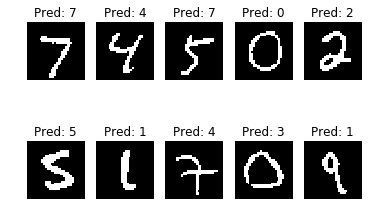

In [18]:
for img_index in range(10):
    res = []
    for i in range(10):
        kk = np.logical_not(np.logical_xor(imgs[img_index, :], BW[i, :].T))
        pop_count = np.sum(kk)
        res.append(pop_count)
    plt.subplot(2, 5, img_index + 1)
    img = np.reshape(imgs[img_index, :], [32, 32])
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title("Pred: " + str(np.argmax(res, axis=0)))
    print(res)
plt.show()